In [2]:
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import nltk, re, string
from string import punctuation
from nltk.corpus import stopwords
from sklearn import metrics
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_auc_score
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Dense, Embedding, Input,LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/fake_news.csv')

df.head()

,Unnamed: 0,title,text,label
0,38760,WATCH WHAT OUR US MILITARY DOES TO PEDOPHILIC ...,Take that you filthy animals!,FAKE
1,35431,WHOA! FOX NEWS HOST JUST BLAMED TRUMP For Viol...,Domestic terrorists are ramping up the violenc...,FAKE
2,9580,"Brexit would hurt Britain, EU and global econo...",BERLIN (Reuters) - If Britain were to leave th...,TRUE
3,6654,Factbox: Contenders for senior jobs in Trump's...,(Reuters) - The following people are mentioned...,TRUE
4,36876,OBAMA’S ARROGANCE: WATCH As He Admonishes Repo...,Being called out for his utter incompetence as...,FAKE


In [5]:
# removing news source info from text
def extract_txt(text):
    regex = re.search(r"(?<=\(Reuters\)\s\-\s).*",text)
    if regex:
        return regex.group(0)
    return text
df['text_processed'] = df['text'].apply(extract_txt)

In [6]:
df.drop(['Unnamed: 0'],axis=1, inplace=True)
df["label"] = df.label.apply(lambda  x:0 if x=='TRUE' else 1)
df.head()


,title,text,label,text_processed
0,WATCH WHAT OUR US MILITARY DOES TO PEDOPHILIC ...,Take that you filthy animals!,1,Take that you filthy animals!
1,WHOA! FOX NEWS HOST JUST BLAMED TRUMP For Viol...,Domestic terrorists are ramping up the violenc...,1,Domestic terrorists are ramping up the violenc...
2,"Brexit would hurt Britain, EU and global econo...",BERLIN (Reuters) - If Britain were to leave th...,0,"If Britain were to leave the European Union, i..."
3,Factbox: Contenders for senior jobs in Trump's...,(Reuters) - The following people are mentioned...,0,The following people are mentioned as contende...
4,OBAMA’S ARROGANCE: WATCH As He Admonishes Repo...,Being called out for his utter incompetence as...,1,Being called out for his utter incompetence as...


In [7]:
#combining text_processed and title for creating full news article with headline
df['final_news'] = df['title'] + " " + df['text_processed']
df.head()

,title,text,label,text_processed,final_news
0,WATCH WHAT OUR US MILITARY DOES TO PEDOPHILIC ...,Take that you filthy animals!,1,Take that you filthy animals!,WATCH WHAT OUR US MILITARY DOES TO PEDOPHILIC ...
1,WHOA! FOX NEWS HOST JUST BLAMED TRUMP For Viol...,Domestic terrorists are ramping up the violenc...,1,Domestic terrorists are ramping up the violenc...,WHOA! FOX NEWS HOST JUST BLAMED TRUMP For Viol...
2,"Brexit would hurt Britain, EU and global econo...",BERLIN (Reuters) - If Britain were to leave th...,0,"If Britain were to leave the European Union, i...","Brexit would hurt Britain, EU and global econo..."
3,Factbox: Contenders for senior jobs in Trump's...,(Reuters) - The following people are mentioned...,0,The following people are mentioned as contende...,Factbox: Contenders for senior jobs in Trump's...
4,OBAMA’S ARROGANCE: WATCH As He Admonishes Repo...,Being called out for his utter incompetence as...,1,Being called out for his utter incompetence as...,OBAMA’S ARROGANCE: WATCH As He Admonishes Repo...


In [8]:
# now we can delete extra columns 
cols_del =['title','text','text_processed']
df = df.drop(cols_del,axis=1)

df.head()

,label,final_news
0,1,WATCH WHAT OUR US MILITARY DOES TO PEDOPHILIC ...
1,1,WHOA! FOX NEWS HOST JUST BLAMED TRUMP For Viol...
2,0,"Brexit would hurt Britain, EU and global econo..."
3,0,Factbox: Contenders for senior jobs in Trump's...
4,1,OBAMA’S ARROGANCE: WATCH As He Admonishes Repo...


In [9]:
#creating list of possible stopwords from nltk library
stop = stopwords.words('english')

def cleanText(txt):
  # lowercaing
    txt = txt.lower()
  # removing stopwords
    txt = ' '.join([word for word in txt.split() if word not in (stop)])
  # removing non-alphabetic characters
    txt = re.sub('[^a-z]',' ',txt)
    return txt  

In [10]:

#applying text cleaning function to clean final_news
df['final_news'] = df['final_news'].apply(cleanText)
df.head()

,label,final_news
0,1,watch us military pedophilic monsters prey inn...
1,1,whoa fox news host blamed trump violence dome...
2,0,brexit would hurt britain eu global economy ...
3,0,factbox contenders senior jobs trump s admini...
4,1,obama s arrogance watch admonishes reporter a...


In [11]:
path = '/content/drive/MyDrive'

EMBEDDING_FILE=f'{path}/glove.6B.50d.txt'

# configuration setting
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 32
EPOCHS = 10

In [12]:
y = df['label'].values
X = df.drop(['label'],axis=1)

In [13]:
y.shape

(44898,)

In [14]:
# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(EMBEDDING_FILE) as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [15]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(list(X['final_news']))
X = tokenizer.texts_to_sequences(list(X['final_news']))

# pad sequences so that we get a N x T matrix
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (44898, 100)


In [16]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 115831 unique tokens.


In [17]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [18]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)

In [19]:
print('Building model...')

# create an LSTM network with a single LSTM
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
# x = LSTM(15, return_sequences=True)(x)
x = Bidirectional(LSTM(15, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)
model.summary()

Building model...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 50)           1000000   
                                                                 
 bidirectional (Bidirectiona  (None, 100, 30)          7920      
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 30)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 1,007,951
Trainable params: 7

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20,stratify=y, random_state=0)

In [21]:
print('Training model...')
r = model.fit(
  X_train,
  y_train,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Training model...
Epoch 1/10
898/898 [==============================] - 23s 13ms/step - loss: 0.2519 - accuracy: 0.9004 - val_loss: 0.1437 - val_accuracy: 0.9500
Epoch 2/10
898/898 [==============================] - 11s 12ms/step - loss: 0.1313 - accuracy: 0.9517 - val_loss: 0.1058 - val_accuracy: 0.9619
Epoch 3/10
898/898 [==============================] - 11s 12ms/step - loss: 0.0984 - accuracy: 0.9646 - val_loss: 0.0868 - val_accuracy: 0.9704
Epoch 4/10
898/898 [==============================] - 11s 12ms/step - loss: 0.0768 - accuracy: 0.9718 - val_loss: 0.0857 - val_accuracy: 0.9699
Epoch 5/10
898/898 [==============================] - 11s 12ms/step - loss: 0.0669 - accuracy: 0.9760 - val_loss: 0.0712 - val_accuracy: 0.9737
Epoch 6/10
898/898 [==============================] - 11s 12ms/step - loss: 0.0639 - accuracy: 0.9784 - val_loss: 0.0631 - val_accuracy: 0.9773
Epoch 7/10
898/898 [==============================] - 11s 12ms/step - loss: 0.0539 - accuracy: 0.9812 - val_loss: 0.06

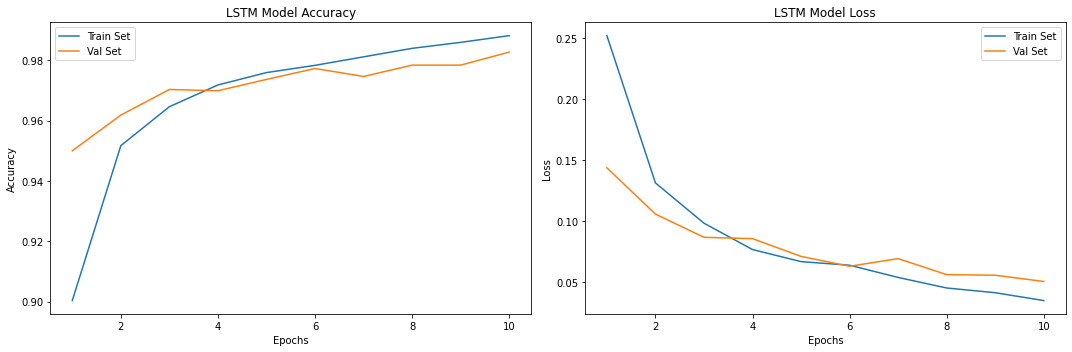

In [23]:
acc = r.history['accuracy']
val_acc = r.history['val_accuracy']
loss = r.history['loss']
val_loss = r.history['val_loss']
epochs_range = range(1, len(r.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('LSTM Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM Model Loss')

plt.tight_layout()
plt.show()

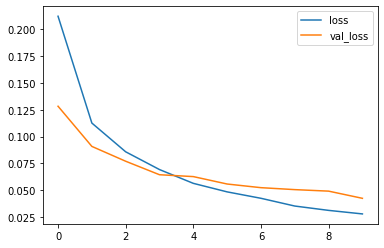

In [111]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

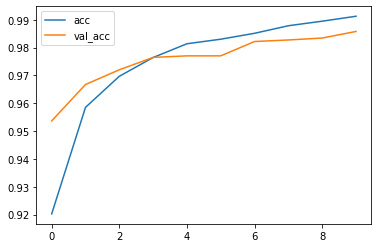

In [112]:
# Plotting accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [113]:
print("Accuracy of the model on Training Data is - " , model.evaluate(X_train,y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100)

1123/1123 [==============================] - 6s 5ms/step - loss: 0.0245 - accuracy: 0.9929
Accuracy of the model on Training Data is -  99.29283261299133
281/281 [==============================] - 1s 5ms/step - loss: 0.0480 - accuracy: 0.9839
Accuracy of the model on Testing Data is -  98.38529825210571


In [114]:
pred = model.predict(X_test)
pred[:5]

array([[0.99823195],
       [0.01543198],
       [0.9875164 ],
       [0.99837697],
       [0.99995315]], dtype=float32)

## Confusion Matrix

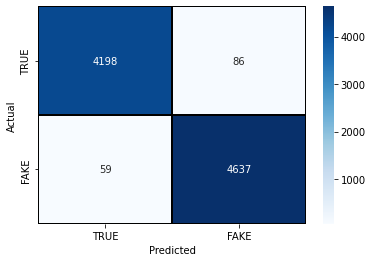

In [115]:
cm = confusion_matrix(y_test,pred.round())
cm = pd.DataFrame(cm , index = ['TRUE','FAKE'] , columns = ['TRUE','FAKE'])
plt.figure(figsize = (6,4))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['TRUE','FAKE'] , yticklabels = ['TRUE','FAKE'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Classification report

In [116]:
print(classification_report(y_test,pred.round()))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      4284
           1       0.98      0.99      0.98      4696

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980



In [117]:
y_pred = model.predict(X_test).ravel()

## ROC AUC PLOT

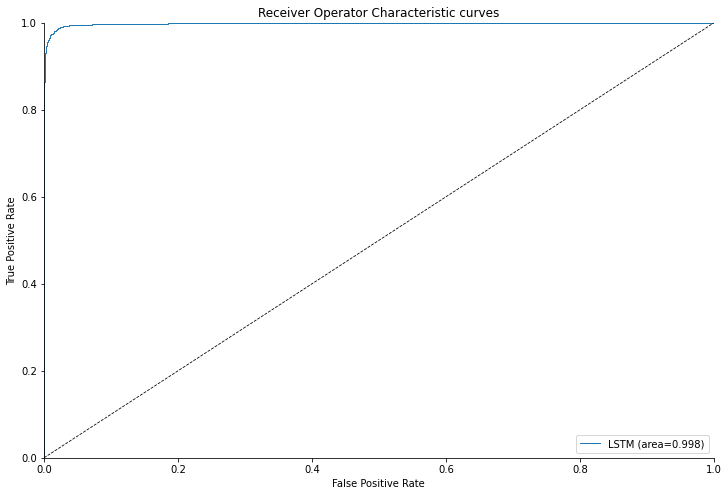

In [118]:
def roc_auc_plot(y_true, y_proba, label=' ', l='-', lw=1.0):
    from sklearn.metrics import roc_curve, roc_auc_score
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    ax.plot(fpr, tpr, linestyle=l, linewidth=lw,
            label="%s (area=%.3f)"%(label,roc_auc_score(y_true, y_proba)))

f, ax = plt.subplots(figsize=(12,8))

roc_auc_plot(y_test,y_pred,label='LSTM', l='-')



ax.plot([0,1], [0,1], color='k', linewidth=0.8, linestyle='--', 
        )    
ax.legend(loc="lower right")    
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_title('Receiver Operator Characteristic curves')
sns.despine()

## Model prediction

In [27]:
testSent =["Trey Gowdy destroys this clueless DHS employee when asking about the due process of getting on the terror watch list. Her response is priceless:  I m sorry, um, there s not a process afforded the citizen prior to getting on the list.  ",
       "Poland s new prime minister faces a difficult balancing act trying to repair bruised relations with the European Union without alienating the eurosceptic government s core voters. A Western-educated former banker who is fluent in German and English and was sworn in on Monday, Mateusz Morawiecki boasts the credentials needed to negotiate with Brussels. But any compromises to improve relations with Brussels, which sees the ruling Law and Justice (PiS) party as a threat to democracy, would risk upsetting the traditional, Catholic supporters who propelled it into power two years ago. It is a gamble that could backfire, and it is not yet clear how far Morawiecki, 49, and his party, dominated by former Prime Minister Jaroslaw Kaczynski, are ready to go to please Brussels.   The idea to build up international credibility seems rational,  said Jaroslaw Flis, a sociologist at the Jagiellonian University.  But such actions would have to be in complete contrast with what Mateusz Morawiecki would have to do domestically to prevent the PiS from falling apart.  The PiS government has alienated many people at home and abroad with its nationalist rhetoric and changes to state institutions which the EU says subvert the bloc s laws. The European Commission, the EU executive, opened an inquiry into the rule of law in Poland in January 2016 and the European Parliament has started a process that could deprive Poland of its voting rights in the 28-nation bloc. Any hope in Brussels that Morawiecki s appointment signals a change of course by PiS will have been tempered by Polish parliament approving legal changes to the judiciary in defiance of the EU on Friday - the day after his nomination. The changes give parliament, where PiS has a majority, de facto control over the selection of judges. EU leaders looking for clues about Morawiecki s plans will also have taken little comfort from comments he has made since being nominated, making clear he backs a tough line on the EU and believes in PiS s traditional vision of the Polish state.   We want to transform Europe, this is my dream, to re-christianise it,  Morawiecki told the Catholic Radio Maryja broadcaster.  We want Poland to be strong, but also to contain ... Christian values. We will defend them against the background of laicisation and a deepening consumerism.  Asked by the radio interviewer about demands by French President Emmanuel Macron for Poland to face sanctions over a subversion of democratic rules, Morawiecki said he would not  bow down to blackmail.  In comments to parliament on Tuesday, Morawiecki suggested Poland might relent in a conflict with Brussels over logging in an ancient forest, which an EU court has said contravenes EU laws. But he said Poland s national interests came first in any debate over the future of the EU and that he  wholeheartedly  supported PiS s overhaul of the judiciary. Like Beata Szydlo, whom he replaced as prime minister, Morawiecki is likely to have to defer to PiS leader and co-founder Jaroslaw Kaczynski. Prime minister from July 2006 to November 2007, Kaczynski is widely seen as the power behind the party and Poland s main decision-maker. How much scope that will leave Morawiecki to carve out his own path remains to be seen. Former Polish President Lech Walesa, a PiS critic, has suggested that nothing of substance will change.  The circus has stayed the same, only the clowns have changed their roles,  Walesa, who led the Solidarity trade union movement that ended communist rule, said on Twitter.  The appointment of Morawiecki, whose father founded and led a radical offshoot of Solidarity in the 1980s, appears designed in part to present a new face of Poland to the EU. Szydlo, 54, at times responded angrily to EU criticism and relations with the bloc soured under her government. Underlining PiS opposition to Muslim immigration, she said last month Poland wanted to be sure Christian traditions were not subject to  ideological censorship  in the EU. Along with Hungary, Poland has refused to take in any of its quota of the wave of refugees from Syria and elsewhere who have come to Europe since 2015, on the grounds that Muslim immigrants are a threat to national security and stability.         Such comments appeal to core PiS voters, and Szydlo s government, which promised generous welfare payouts and a dedication to traditional Catholic values, was one of Poland s most popular since communist rule ended in 1989. A relative newcomer to politics, Morawiecki lacks Szydlo s broad appeal. But he has overseen significant economic achievements since becoming finance minister in 2016, a position he has retained in the new government. Tusk has welcomed what he sees as signs that Morawiecki is a liberal economist who wants better ties with the EU.  There is no doubt that (Morawiecki s) liberal bias and some pro-western gestures could be a sign that there is a lurking desire to improve relations,  Tusk said last week. But an economic stimulus plan Morawiecki unveiled in 2016 has been criticized by economists who say it depends heavily on private investment, which is low in Poland despite fast economic growth.  What Morawiecki sees as a solution, meaning more political influence in the economy, is actually dangerous,  said Leszek Balcerowicz, a former finance minister who coordinated the transition to a market economy after decades of communist rule. Any hint of protectionism is also likely to worry EU leaders, who seek to break down trade barriers.  Morawiecki has called the privatization of state-owned companies a tragedy and said he will give more power to domestic capital at the expense of foreign investors. In his comments to parliament on Tuesday, he said economic policy should not change.  ",
      ]

In [28]:
def cleanText(txt):
    txt = txt.lower()
    txt = ' '.join([word for word in txt.split() if word not in (stop)])
    txt = re.sub('[^a-z]',' ',txt)
    return txt  


In [29]:
def predict_text(lst_text):
    test = tokenizer.texts_to_sequences(lst_text)
    # pad sequences so that we get a N x T matrix
    testX = pad_sequences(test, maxlen=MAX_SEQUENCE_LENGTH)
    df_test = pd.DataFrame(lst_text, columns = ['test_sent'])

    prediction = model.predict(testX)
    df_test['prediction']=prediction
    df_test["test_sent"] = df_test["test_sent"].apply(cleanText)
    df_test['prediction']=df_test['prediction'].apply(lambda x: "Fake" if x>=0.5 else "Real")
    return df_test

In [30]:
df_testsent = predict_text(testSent)
df_testsent

,test_sent,prediction
0,trey gowdy destroys clueless dhs employee aski...,Fake
1,poland new prime minister faces difficult bala...,Real
